In [296]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st

In [297]:
# This strategy is for TLT.

In [298]:
tlt = yf.Ticker("TLT")
df = tlt.history(period = "max")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-07-30,41.352739,41.428616,41.236393,41.236393,6100,0.000,0
2002-07-31,41.453909,41.883879,41.428619,41.747299,29400,0.000,0
2002-08-01,41.752351,41.995154,41.752351,41.985039,25000,0.000,0
2002-08-02,42.065994,42.541485,41.924354,42.415024,52800,0.000,0
2002-08-05,42.511109,42.713448,42.414998,42.602161,61100,0.000,0
...,...,...,...,...,...,...,...
2022-12-14,107.400209,108.058612,106.632062,107.899002,19517500,0.000,0
2022-12-15,108.389999,109.120003,108.160004,108.320000,20246200,0.261,0
2022-12-16,106.599998,107.830002,106.309998,107.110001,20835200,0.000,0


In [299]:
df = df.drop(["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"], axis = 1)
df["Month"] = df.index.month
df["Day"] = df.index.day
df["buy"] = [0] * len(df)
df["sell"] = [0] * len(df)
#df["cover_short"] = [0] * len(df)
df

,Close,Month,Day,buy,sell
Date,,,,,
2002-07-30,41.236393,7,30,0,0
2002-07-31,41.747299,7,31,0,0
2002-08-01,41.985039,8,1,0,0
2002-08-02,42.415024,8,2,0,0
2002-08-05,42.602161,8,5,0,0
...,...,...,...,...,...
2022-12-14,107.899002,12,14,0,0
2022-12-15,108.320000,12,15,0,0
2022-12-16,107.110001,12,16,0,0


In [300]:
type(df.index)  # Date index is DateTime type.

pandas.core.indexes.datetimes.DatetimeIndex

In [301]:
# Set the initial capital
initial_capital= float(10000)

In [302]:
df.loc[
    (
        ((df["Month"] != 2) &  # If month is not February, buy 5 days before end of month (25th day or if weekend 23rd day.)
        ((df["Day"] >= 22) &
        (df["Day"] <= 24))) |
        
        ((df["Month"] == 2) &  # If month is February, buy 5 days before end of month (23rd day or if weekend 21st day.)
        ((df["Day"] >= 20) &
        (df["Day"] <= 22)))
    ),
    
"buy"] = 1

# But this causes adjacent "buy" = 1 values.

df.loc[
    (
 
        ((df["Month"] != 2) &  # If month is not February, sell on last day of month (30th day or if weekend 28th day.)
        (df["Day"] >= 29) &
        (df["Day"] <= 31)) |
        
        ((df["Month"] == 2) &  # If month is February, sell on last day of month (28th day or if weekend 26th day.)
        (df["Day"] >= 26) &
        (df["Day"] <= 28))
    ),
    
"sell"] = 1

# Sell. But this causes adjacent "sell" = 1 values.

In [303]:
""" df.loc[
    (
        (df["buy"].shift(1) == 1)
    ),
    
"buy"] = 0

# Clean the buy values.

df.loc[
    ( 
        (df["sell"].shift(1) == 1)
    ),
    
"sell"] = 0

# Clean the sell values. """

' df.loc[\n    (\n        (df["buy"].shift(1) == 1)\n    ),\n    \n"buy"] = 0\n\n# Clean the buy values.\n\ndf.loc[\n    ( \n        (df["sell"].shift(1) == 1)\n    ),\n    \n"sell"] = 0\n\n# Clean the sell values. '

In [304]:
df

,Close,Month,Day,buy,sell
Date,,,,,
2002-07-30,41.236393,7,30,0,1
2002-07-31,41.747299,7,31,0,1
2002-08-01,41.985039,8,1,0,0
2002-08-02,42.415024,8,2,0,0
2002-08-05,42.602161,8,5,0,0
...,...,...,...,...,...
2022-12-14,107.899002,12,14,0,0
2022-12-15,108.320000,12,15,0,0
2022-12-16,107.110001,12,16,0,0


In [305]:
cash_contracts_equity = [initial_capital, 0, initial_capital]
cash_contracts_equity = np.array([cash_contracts_equity] * len(df))

cash_contracts_equity[0][0] = initial_capital  # cash
cash_contracts_equity[0][1] = 0  # contracts
cash_contracts_equity[0][2] = initial_capital  # equity

cash_contracts_equity

array([[10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       ...,
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.]])

In [306]:
cash_contracts_equity[0][0]

10000.0

In [307]:
df[0:50]

,Close,Month,Day,buy,sell
Date,,,,,
2002-07-30,41.236393,7,30,0,1
2002-07-31,41.747299,7,31,0,1
2002-08-01,41.985039,8,1,0,0
2002-08-02,42.415024,8,2,0,0
2002-08-05,42.602161,8,5,0,0
2002-08-06,42.237976,8,6,0,0
2002-08-07,42.339100,8,7,0,0
2002-08-08,42.339100,8,8,0,0
2002-08-09,42.936016,8,9,0,0


In [308]:
for index, _row in enumerate(df.iterrows()):
    row = _row[1]
    
    if index == 0:
        cash_contracts_equity[index][0] == initial_capital
        cash_contracts_equity[index][1] == 0
        cash_contracts_equity[index][2] == initial_capital
    else:
        if row["buy"] == 1:
            if cash_contracts_equity[index - 1][0] == 0:
                cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
                cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
            else:
                cash_contracts_equity[index][1] = (cash_contracts_equity[index - 1][0] / row["Close"])
                cash_contracts_equity[index][0] = 0
        
        elif row["sell"] == 1:
            if cash_contracts_equity[index - 1][1] == 0:
                cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
                cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
            else:
                cash_contracts_equity[index][0] = (cash_contracts_equity[index - 1][1] * row["Close"])
                cash_contracts_equity[index][1] = 0
        
        elif row["buy"] == 0 and row["sell"] == 0:
            cash_contracts_equity[index][1] = cash_contracts_equity[index - 1][1]
            cash_contracts_equity[index][0] = cash_contracts_equity[index - 1][0]
        
            
        cash_contracts_equity[index][2] = (cash_contracts_equity[index][0] + (cash_contracts_equity[index][1] * row["Close"]))

In [309]:
cash_contracts_equity[0:10]

array([[10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.],
       [10000.,     0., 10000.]])

In [310]:
cash_contracts_equity.T

array([[10000.        , 10000.        , 10000.        , ...,
        23111.85322297, 23111.85322297, 23111.85322297],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [10000.        , 10000.        , 10000.        , ...,
        23111.85322297, 23111.85322297, 23111.85322297]])

In [311]:
df["cash"] = cash_contracts_equity.T[0]
df["contracts"] = cash_contracts_equity.T[1]
df["equity"] = cash_contracts_equity.T[2]
df["equity_pc"] = df["equity"].pct_change()
df["TLT_pc"] = df["Close"].pct_change()
df["equity_cr"] = (1 + df["equity_pc"]).cumprod()
df["TLT_cr"] = (1 + df["TLT_pc"]).cumprod()
#df = df.fillna(0)
df[1900:1950]

,Close,Month,Day,buy,sell,cash,contracts,equity,equity_pc,TLT_pc,equity_cr,TLT_cr
Date,,,,,,,,,,,,
2010-02-16,64.487686,2,16,0,0,12856.515151,0.000000,12856.515151,0.000000,0.001885,1.285652,1.563854
2010-02-17,63.752583,2,17,0,0,12856.515151,0.000000,12856.515151,0.000000,-0.011399,1.285652,1.546027
2010-02-18,63.495705,2,18,0,0,12856.515151,0.000000,12856.515151,0.000000,-0.004029,1.285652,1.539798
2010-02-19,63.838226,2,19,0,0,12856.515151,0.000000,12856.515151,0.000000,0.005394,1.285652,1.548104
2010-02-22,63.574184,2,22,1,0,0.000000,202.228550,12856.515151,0.000000,-0.004136,1.285652,1.541701
2010-02-23,64.566223,2,23,0,0,0.000000,202.228550,13057.133704,0.015604,0.015604,1.305713,1.565758
2010-02-24,64.723206,2,24,0,0,0.000000,202.228550,13088.880032,0.002431,0.002431,1.308888,1.569565
2010-02-25,65.087143,2,25,0,0,0.000000,202.228550,13162.478560,0.005623,0.005623,1.316248,1.578391
2010-02-26,65.422646,2,26,0,1,13230.326770,0.000000,13230.326770,0.005155,0.005155,1.323033,1.586527


Text(0.5, 1.0, 'Cumulative compounded returns of TLT and strategy')

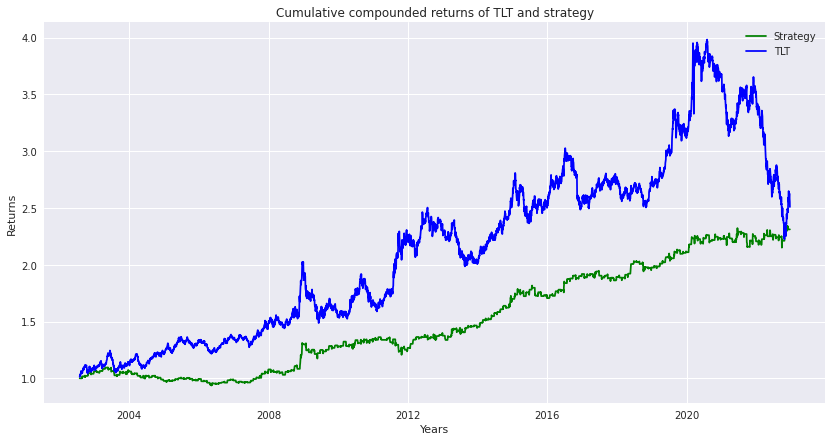

In [312]:
plt.style.use("seaborn")
plt.figure(figsize = (14, 7))
plt.plot(df.index, df["equity_cr"], c = "g", label = "Strategy")
plt.plot(df.index, df["TLT_cr"], c = "b", label = "TLT")
plt.xlabel("Years")
plt.ylabel("Returns")
plt.legend()
plt.title("Cumulative compounded returns of TLT and strategy")

In [313]:
# Annualized sharpe ratios:

df["TLT_sharpe"] = (df["TLT_pc"].rolling(1000).mean() / df["TLT_pc"].rolling(1000).std()) * np.sqrt(252)
df["equity_sharpe"] = (df["equity_pc"].rolling(1000).mean() / df["TLT_pc"].rolling(1000).std()) * np.sqrt(252)

Text(0.5, 1.0, '4-year rolling annualized sharpe ratio of TLT and strategy')

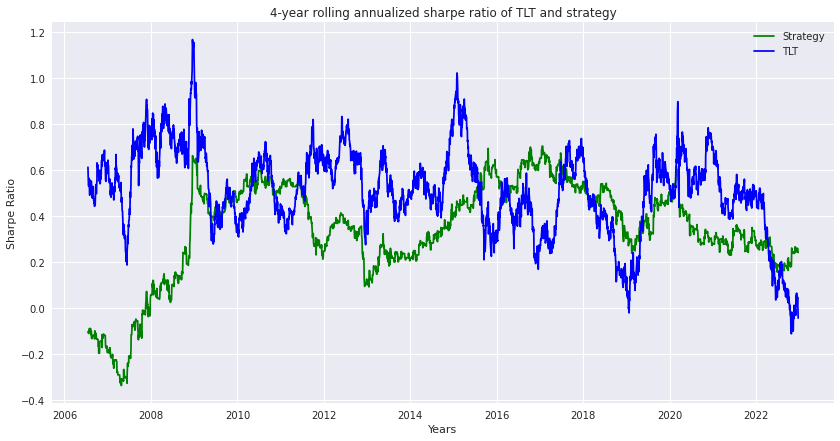

In [314]:
plt.style.use("seaborn")
plt.figure(figsize = (14, 7))
plt.plot(df.index, df["equity_sharpe"], c = "g", label = "Strategy")
plt.plot(df.index, df["TLT_sharpe"], c = "b", label = "TLT")
plt.xlabel("Years")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.title("4-year rolling annualized sharpe ratio of TLT and strategy")

In [ ]:
df["excess_returns_diff"] = (df["equity_pc"] - df["TLT_pc"])
df["information_ratio_strategy"] = (df["excess_returns_diff"].rolling(1000).mean() / df["excess_returns_diff"].rolling(1000).std())

plt.style.use("seaborn")
plt.figure(figsize = (14, 7))
plt.plot(df.index, df["information_ratio_strategy"], c = "g", label = "Strategy information ratio")
plt.xlabel("Years")
plt.ylabel("Information Ratio")
plt.legend()
plt.title("4-year rolling information ratio of strategy")

Text(0.5, 1.0, '4-year rolling volatility of returns of TLT and strategy')

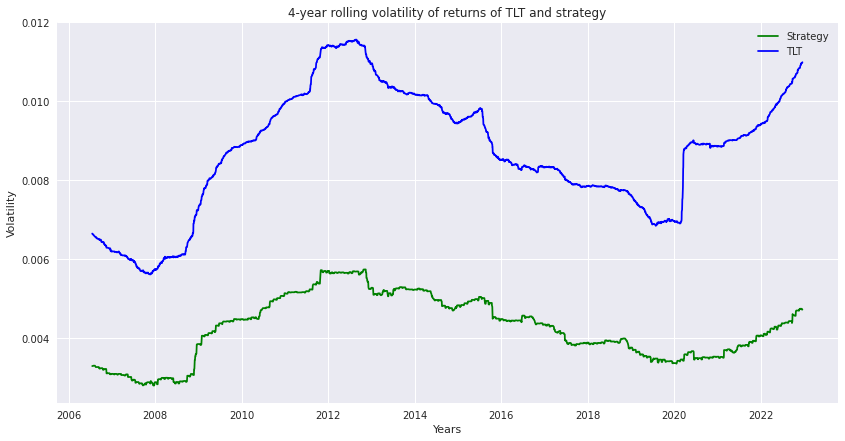

In [315]:
df["TLT_vol"] = df["TLT_pc"].rolling(1000).std()
df["equity_vol"] = df["equity_pc"].rolling(1000).std()

plt.style.use("seaborn")
plt.figure(figsize = (14, 7))
plt.plot(df.index, df["equity_vol"], c = "g", label = "Strategy")
plt.plot(df.index, df["TLT_vol"], c = "b", label = "TLT")
plt.xlabel("Years")
plt.ylabel("Volatility")
plt.legend()
plt.title("4-year rolling volatility of returns of TLT and strategy")

Text(0.5, 1.0, '1-year rolling correlation between TLT and Strategy')

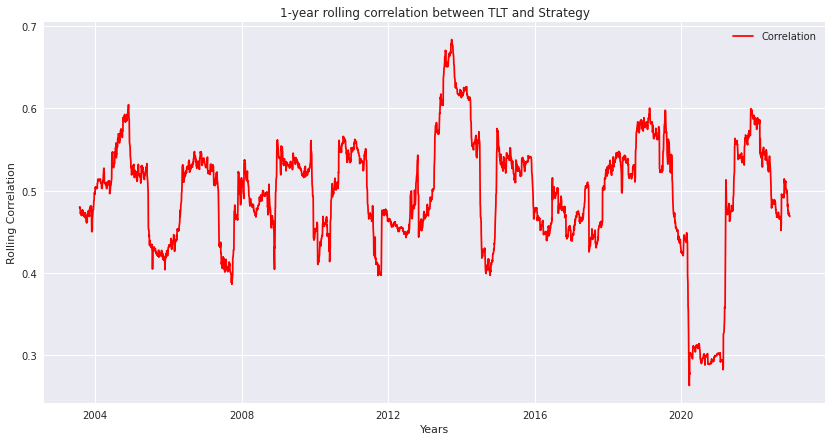

In [316]:
df["corr"] = df['equity_pc'].rolling(252).corr(df['TLT_pc'])  # Rolling 1 year correlation between TLT and strategy gains.

plt.style.use("seaborn")
plt.figure(figsize = (14, 7))
plt.plot(df.index, df["corr"], c = "r", label = "Correlation")
plt.xlabel("Years")
plt.ylabel("Rolling Correlation")
plt.legend()
plt.title("1-year rolling correlation between TLT and Strategy")

In [317]:
df_grouped = df.groupby(['Day']).mean()
df_grouped["equity_pc"]

Day
1     1.139249e-04
2     4.396713e-05
3    -8.741719e-05
4     3.438143e-04
5    -3.529985e-04
6     0.000000e+00
7     2.798527e-05
8     5.584521e-05
9     1.478310e-04
10   -1.446273e-04
11    2.172504e-04
12    1.383210e-04
13    0.000000e+00
14   -1.193659e-04
15    2.551745e-04
16    1.973781e-04
17    4.639710e-04
18    1.858531e-04
19    3.379880e-04
20    1.321694e-18
21   -9.864752e-05
22    1.039084e-04
23    4.618189e-04
24    7.771926e-04
25   -1.875453e-05
26    5.438487e-04
27    5.665512e-04
28    4.396575e-04
29   -4.302239e-05
30    5.060704e-04
31    4.193732e-04
Name: equity_pc, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'TLT: Daily mean price change (%) per day of month')

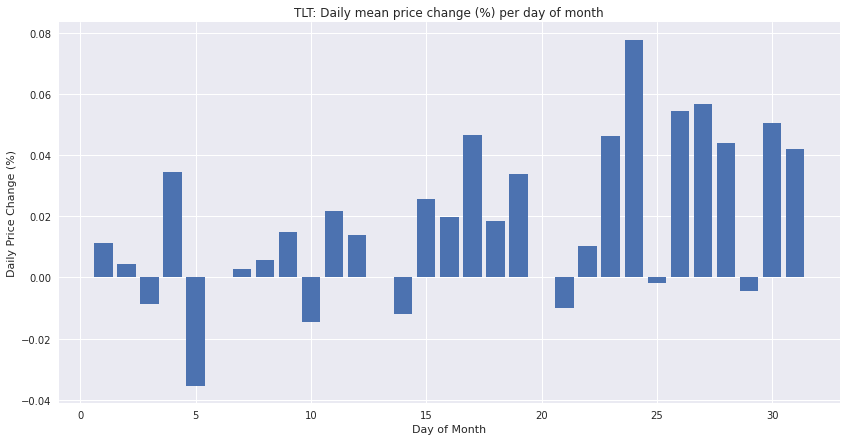

In [318]:
plt.style.use("seaborn")
plt.figure(figsize = (14, 7))
plt.bar(df_grouped.index, (df_grouped["equity_pc"]) * 100)
plt.xlabel("Day of Month")
plt.ylabel("Daily Price Change (%)")
plt.legend()
plt.title("TLT: Daily mean price change (%) per day of month")